In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from matplotlib import colors

import stuff
import plot

np.warnings.filterwarnings('ignore')

In [2]:
BIASED = 1 << 0
BLENDED = 1 << 1
SATURATED = 1 << 2
BOUNDARY = 1 << 3
NEIGHBORS = 1 << 4
ALL_FLAGS = {
    BIASED: 'biased',
    BLENDED: 'blended',
    SATURATED: 'saturated',
    BOUNDARY: 'boundary',
    NEIGHBORS: 'neighbors'
}
FLAG_STYLE = {
    BIASED: dict(c='white', marker='o'),
    BLENDED: dict(c='blue', marker='^'),
    SATURATED: dict(c='red', marker='<'),
    BOUNDARY: dict(c='orange', marker='>'),
    NEIGHBORS: dict(c='green', marker='v'),
}

## Load simulation data

In [3]:
r_stars, r_galaxies = stuff.parse_stuff_list(os.path.expanduser('~/Work/Data/sim08/sim08_r.list'))
g_stars, g_galaxies = stuff.parse_stuff_list(os.path.expanduser('~/Work/Data/sim08/sim08_g.list'))
i_stars, i_galaxies = stuff.parse_stuff_list(os.path.expanduser('~/Work/Data/sim08/sim08_i.list'))

### Build a KDTree with the source coordinates

In [4]:
# Make sure that the coordinates are the same for all simulations!
assert(np.all(r_stars.ra == g_stars.ra) and np.all(r_stars.dec == g_stars.dec))
assert(np.all(r_galaxies.ra == g_galaxies.ra) and np.all(r_galaxies.dec == g_galaxies.dec))
assert(np.all(r_galaxies.ra == i_galaxies.ra) and np.all(r_galaxies.dec == i_galaxies.dec))

kdtree, n_stars, n_galaxies = stuff.index_sources(r_stars, r_galaxies)

n_stars = len(r_stars)
n_galaxies = len(r_galaxies)

r_mags = np.append(r_stars.mag, r_galaxies.mag)
g_mags = np.append(g_stars.mag, g_galaxies.mag)
i_mags = np.append(i_stars.mag, i_galaxies.mag)

## Load the output catalog

In [5]:
output_catalog = Table.read(os.path.expanduser('~/Work/Data/sim08/multiframe_output.fits'))
closest = stuff.get_closest(output_catalog, kdtree)
len(output_catalog)

1443

Compute average magnitudes taking into account the exposure time, since the magnitude field on the catalog doesn't.

In [6]:
# This comes from sim09_*_sky.conf
mag_zeropoint = 26.
exp_time = 300.

In [7]:
# Need to massage the catalog first
for i in range(30):
    auto_mag_cname = f'auto_mag_{i}'
    flux_cname = f'auto_flux_{i}'
    mag_cname = f'mag_{i}'
    # Replace 99 with nan to make filtering easier
    output_catalog[auto_mag_cname][output_catalog[auto_mag_cname] >= 99.] = np.nan
    output_catalog[flux_cname][output_catalog[flux_cname] == 0.] = np.nan
    # Compute he magnitude for each frame
    output_catalog[mag_cname] = mag_zeropoint - 2.5 * np.log10(output_catalog[flux_cname] / exp_time)

In [8]:
aggregated_flags = {}
aggregated_flags['g'] = np.bitwise_or.reduce(
    np.stack([(output_catalog[f'auto_flags_{i}']) for i in range(10)], axis=1),
    axis=1
)
aggregated_flags['r'] = np.bitwise_or.reduce(
    np.stack([(output_catalog[f'auto_flags_{i}']) for i in range(10,20)], axis=1),
    axis=1
)
aggregated_flags['i'] = np.bitwise_or.reduce(
    np.stack([(output_catalog[f'auto_flags_{i}']) for i in range(20,30)], axis=1),
    axis=1
)

count = {}
count['g'] = np.array([ (aggregated_flags['g'] & flag).astype(np.bool).sum() for flag in ALL_FLAGS.keys() ])
count['i'] = np.array([ (aggregated_flags['i'] & flag).astype(np.bool).sum() for flag in ALL_FLAGS.keys() ])
count['r'] = np.array([ (aggregated_flags['r'] & flag).astype(np.bool).sum() for flag in ALL_FLAGS.keys() ])

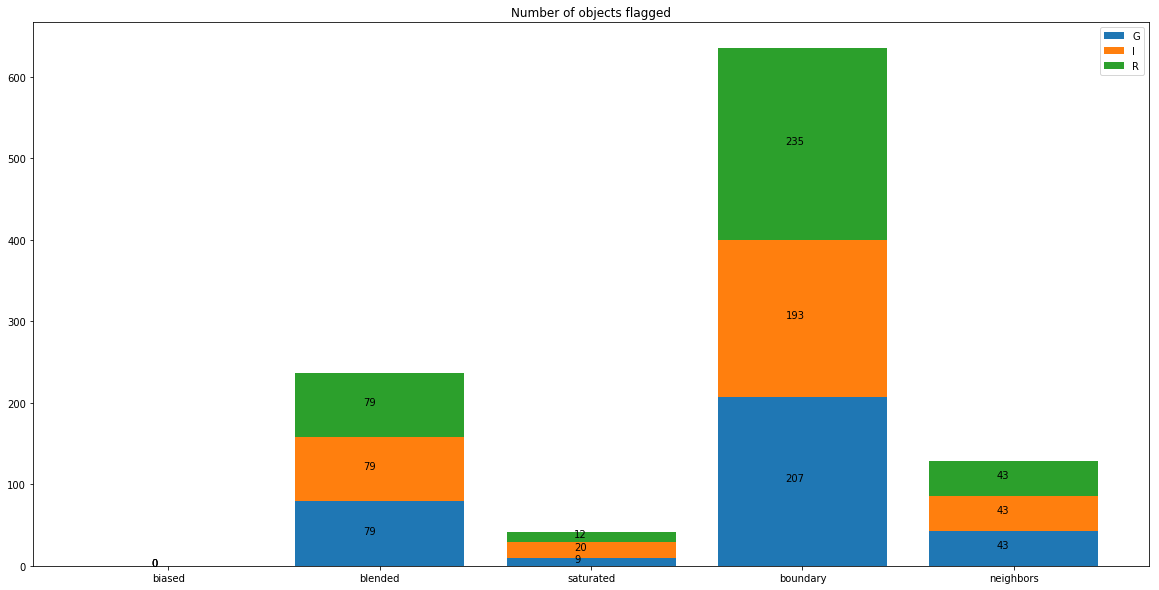

In [9]:
plt.figure(figsize=(20,10))
plt.title('Number of objects flagged')
rects = plt.bar(ALL_FLAGS.values(), count['g'], label='G')
rects += plt.bar(ALL_FLAGS.values(), count['i'], bottom=count['g'], label='I')
rects += plt.bar(ALL_FLAGS.values(), count['r'], bottom=count['i'] + count['g'], label='R')
_ = plt.legend()

for rect in rects:
    plt.text(rect.get_x() + rect.get_width()/2.5, rect.get_y() + rect.get_height()/2., f'{rect.get_height()}')

# Display flags

In [10]:
def display_flags(band):
    img = fits.open(os.path.expanduser(f'~/Work/Data/sim08/sim08_{band}.fits'))[0]

    plt.figure(figsize=(15,15))
    plt.imshow(img.data, cmap=plt.get_cmap('Greys_r'), norm=colors.SymLogNorm(10))
    for flag, flag_name in ALL_FLAGS.items():
        subset = output_catalog[(aggregated_flags[band] & flag).astype(np.bool)]
        plt.scatter(subset['pixel_centroid_x'], subset['pixel_centroid_y'], label=flag_name, alpha=0.5, **FLAG_STYLE[flag])
    plt.legend()
    plt.title(band)

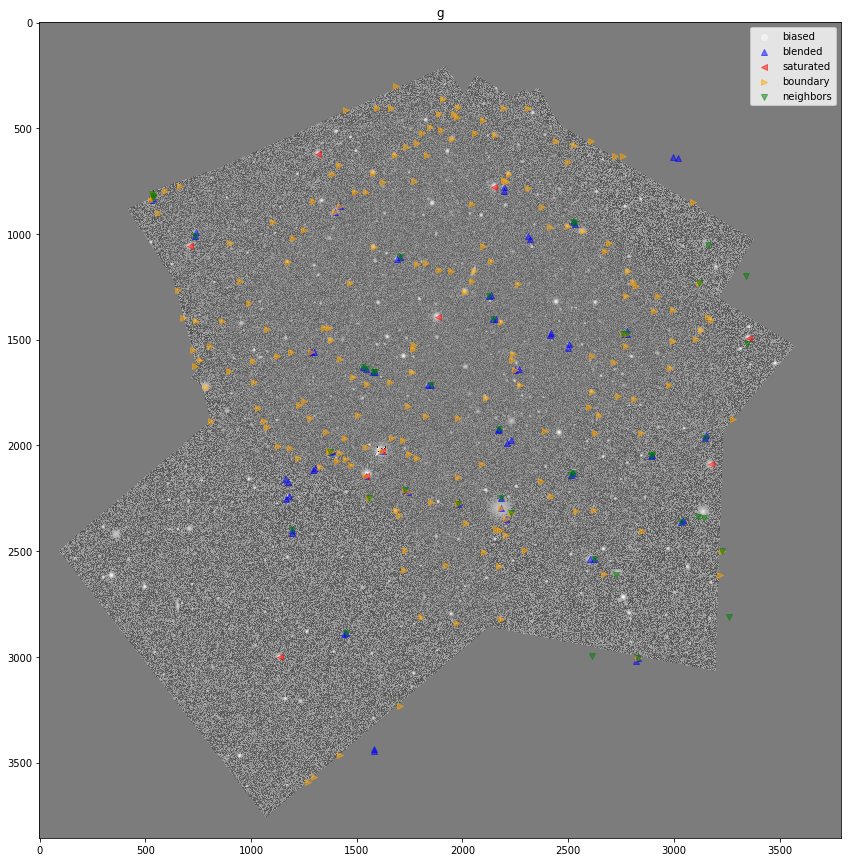

In [11]:
display_flags('g')

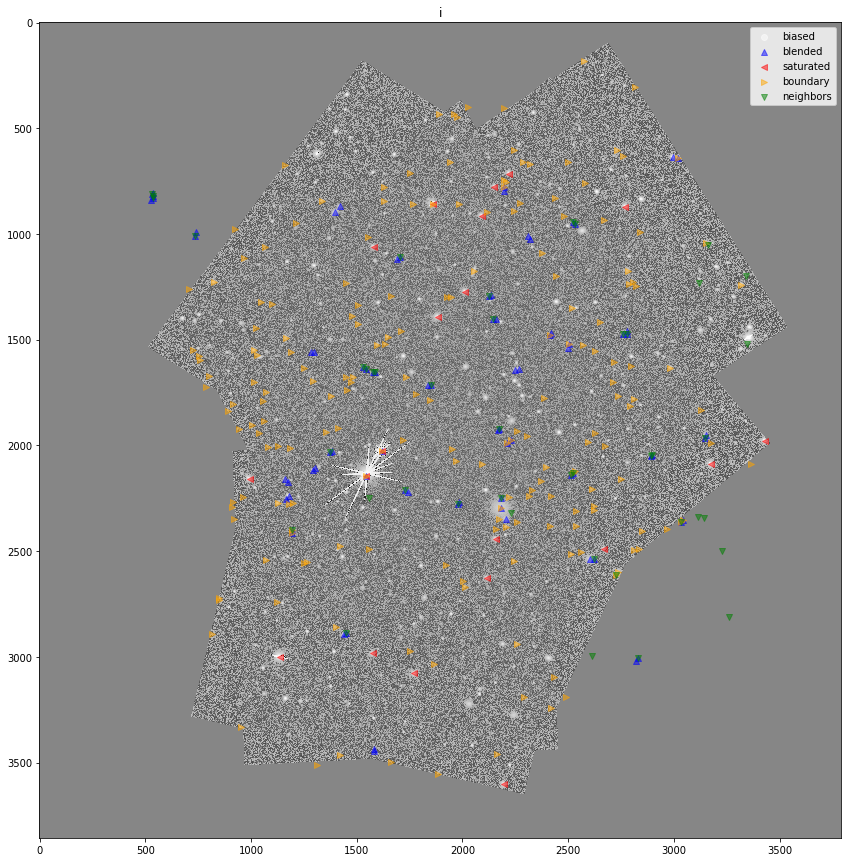

In [12]:
display_flags('i')

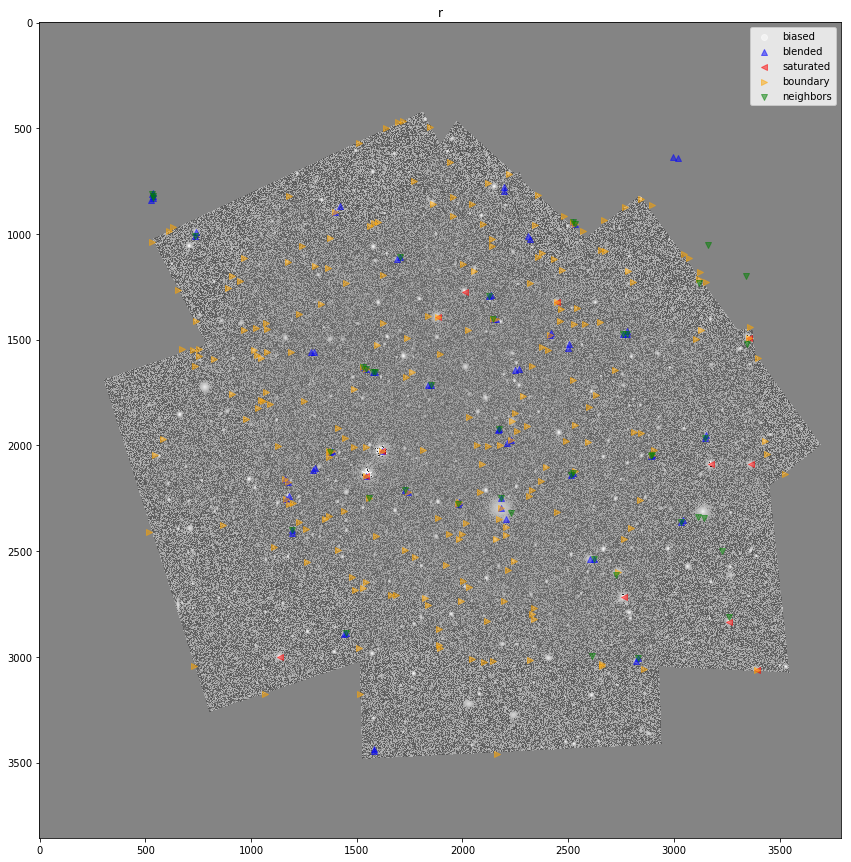

In [13]:
display_flags('r')

# Scatter plots

In [14]:
for i, b in enumerate(['g', 'r', 'i']):
    mags = np.stack([(output_catalog[f'mag_{j + i * 10}']) for j in range(0,10)], axis=1)
    flagged = np.stack([(output_catalog[f'auto_flags_{j + i * 10}']) for j in range(0,10)], axis=1).astype(np.bool)
    output_catalog[f'mag_not_corrected_{b}'] = np.nanmean(mags, axis=1)
    mags[flagged] = np.nan
    output_catalog[f'mag_{b}'] = np.nanmean(mags, axis=1)

In [15]:
# Compute difference between obtained and expected magnitudes, using the average
g_mag_diff = output_catalog[closest['catalog']]['mag_g'] - g_mags[closest['source']]
r_mag_diff = output_catalog[closest['catalog']]['mag_r'] - r_mags[closest['source']]
i_mag_diff = output_catalog[closest['catalog']]['mag_i'] - i_mags[closest['source']]

# Filter NaN and outliers
r_not_nan = (np.isnan(r_mag_diff) == False)
g_not_nan = (np.isnan(g_mag_diff) == False)
i_not_nan = (np.isnan(i_mag_diff) == False)
r_outlier_filter = (r_mag_diff >= np.percentile(r_mag_diff[r_not_nan], 5)) & (r_mag_diff <= np.percentile(r_mag_diff[r_not_nan], 95)) & r_not_nan
g_outlier_filter = (g_mag_diff >= np.percentile(g_mag_diff[g_not_nan], 5)) & (g_mag_diff <= np.percentile(g_mag_diff[g_not_nan], 95)) & g_not_nan
i_outlier_filter = (i_mag_diff >= np.percentile(i_mag_diff[i_not_nan], 5)) & (i_mag_diff <= np.percentile(i_mag_diff[i_not_nan], 95)) & i_not_nan

## Scatter plot with average magnitude excluding flagged values

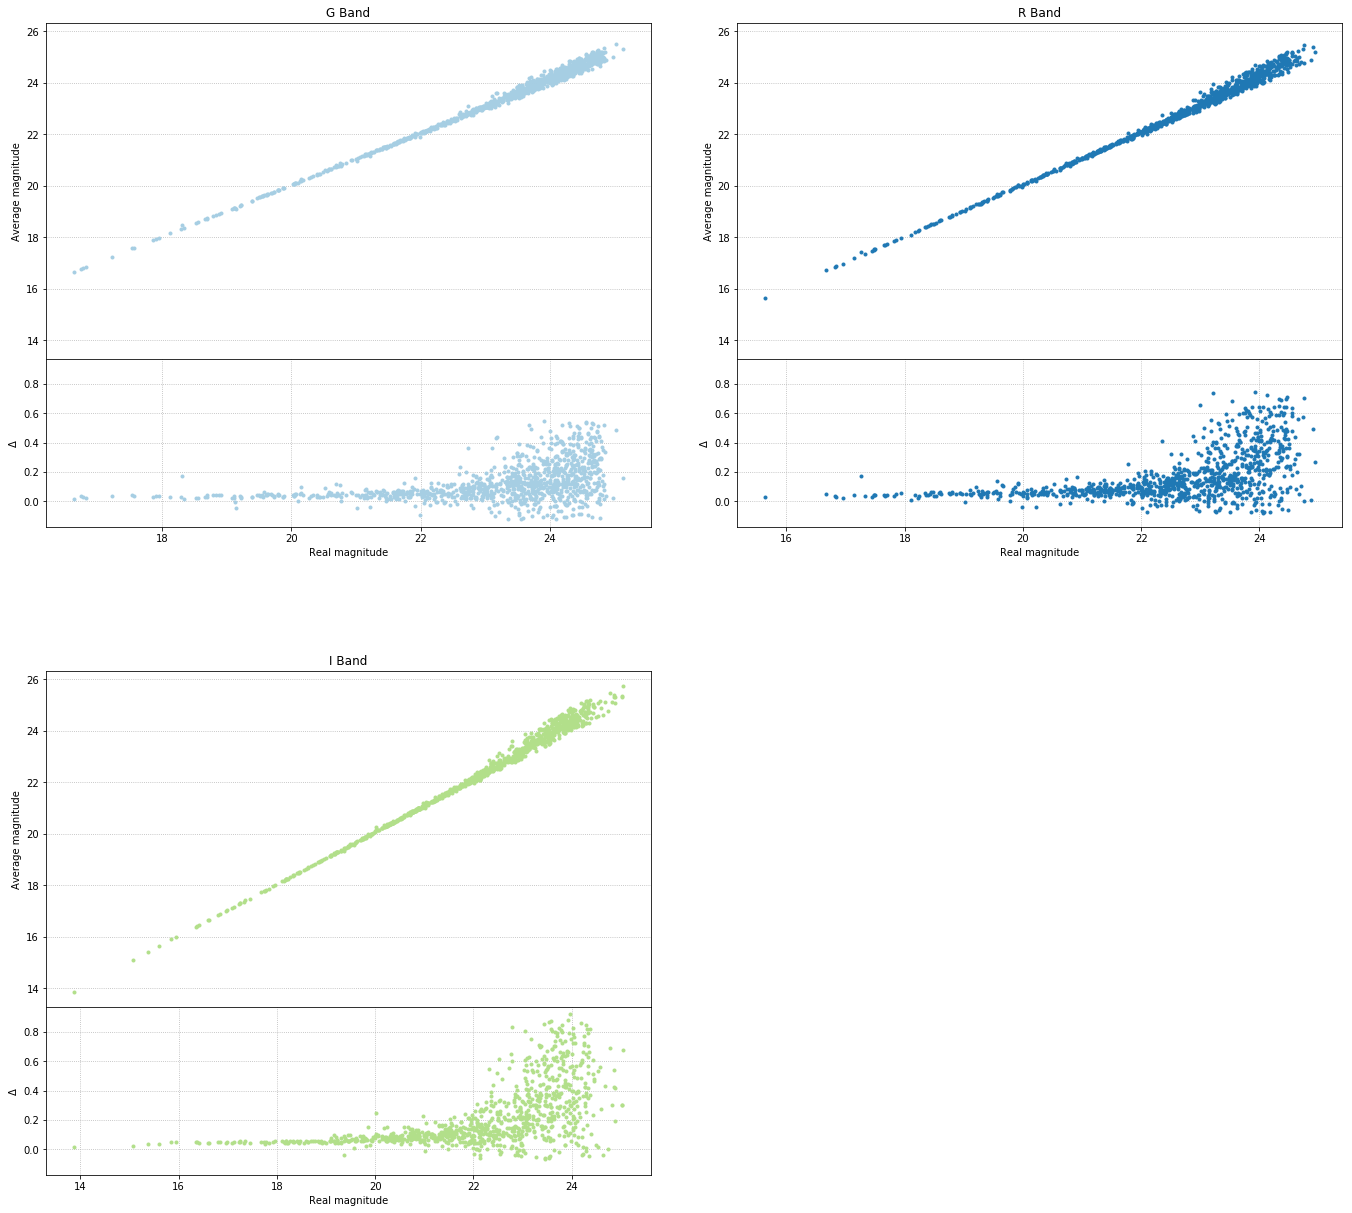

In [16]:
plot.scatter_delta([
    (
        g_mags[closest['source']][g_outlier_filter], output_catalog[closest['catalog']]['mag_g'][g_outlier_filter],
        'G Band'
    ),
    (
        r_mags[closest['source']][r_outlier_filter], output_catalog[closest['catalog']]['mag_r'][r_outlier_filter],
        'R Band'
    ),
    (
        i_mags[closest['source']][i_outlier_filter], output_catalog[closest['catalog']]['mag_i'][i_outlier_filter],
        'I Band'
    ),
], figsize=(20,20), ylabel='Average magnitude', ydeltalabel='$\Delta$', xlabel='Real magnitude')


## Scatter plot with average magnitude using all values

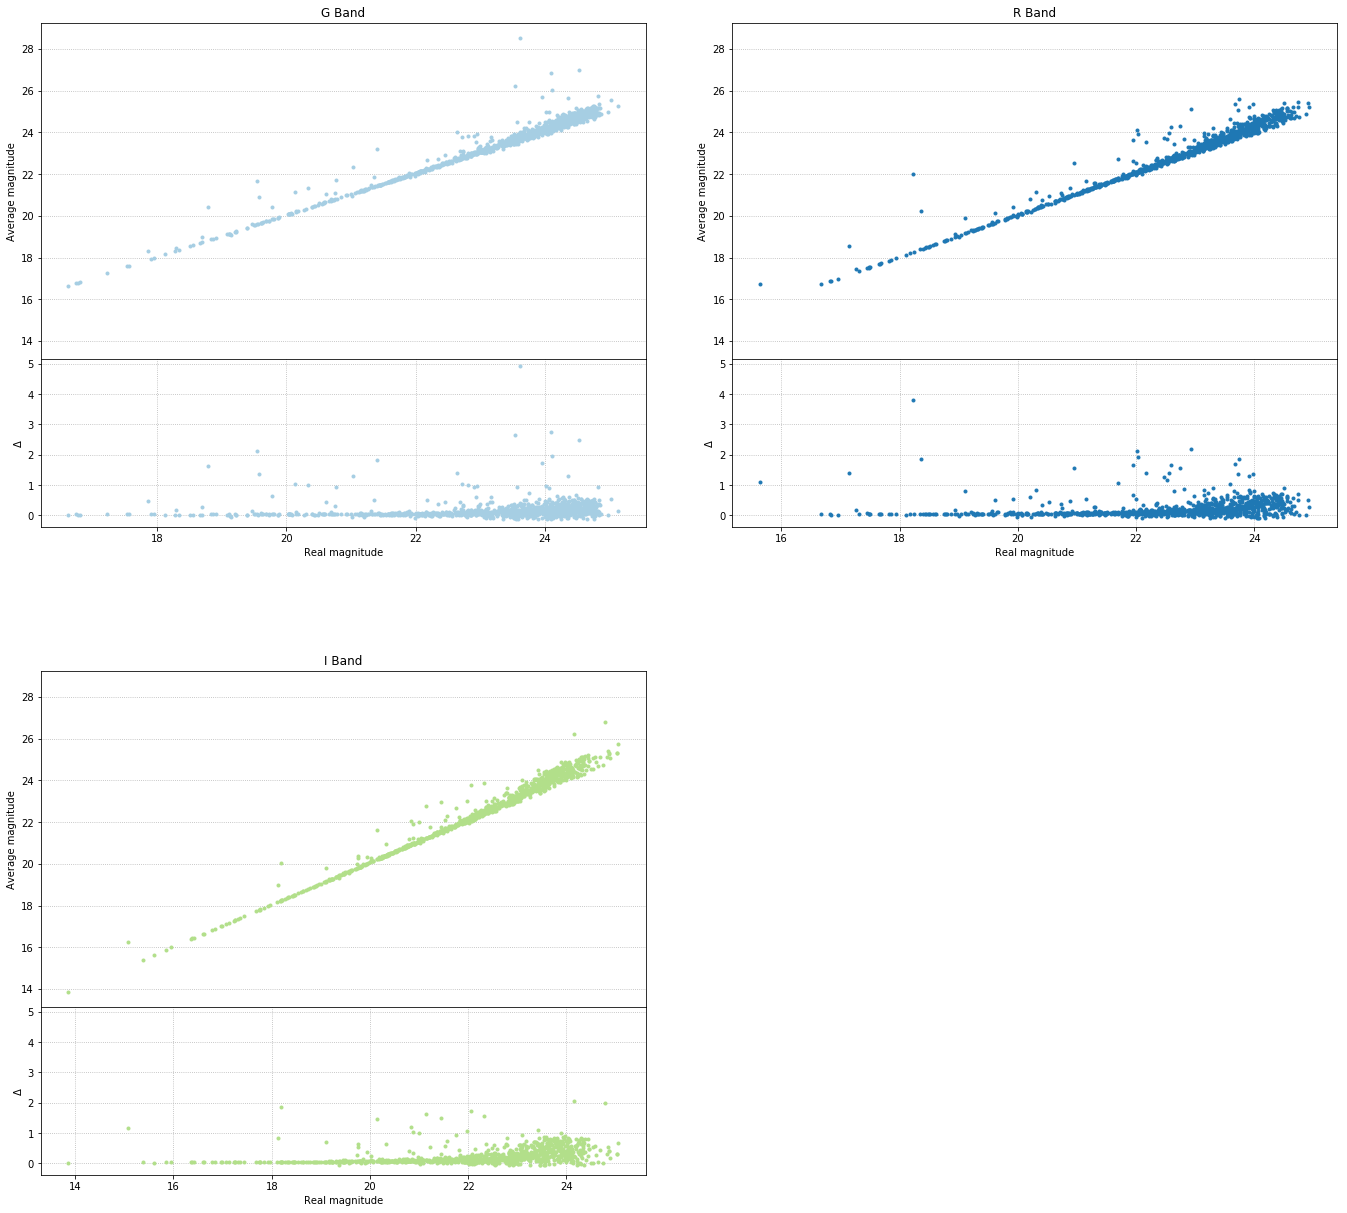

In [17]:
plot.scatter_delta([
    (
        g_mags[closest['source']][g_outlier_filter], output_catalog[closest['catalog']]['mag_not_corrected_g'][g_outlier_filter],
        'G Band'
    ),
    (
        r_mags[closest['source']][r_outlier_filter], output_catalog[closest['catalog']]['mag_not_corrected_r'][r_outlier_filter],
        'R Band'
    ),
    (
        i_mags[closest['source']][i_outlier_filter], output_catalog[closest['catalog']]['mag_not_corrected_i'][i_outlier_filter],
        'I Band'
    ),
], figsize=(20,20), ylabel='Average magnitude', ydeltalabel='$\Delta$', xlabel='Real magnitude')
